#House Prices: Advanced Regression Techniques


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
housing_train = pd.read_csv('train.csv', delimiter=',')
housing_test = pd.read_csv('test.csv', delimiter=',')

test_ids = housing_test['Id']

First of all, I looked at distribution of the sales prices in training data

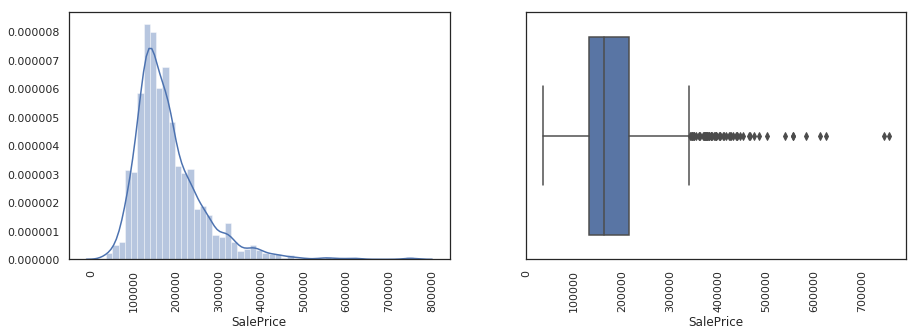

In [3]:
sns.set(style="white")
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.distplot(housing_train['SalePrice'])
plt.xticks(rotation=90)
plt.subplot(2,2,2)
sns.boxplot(housing_train['SalePrice'])
plt.xticks(rotation=90)
plt.show()

SalePrice data is skewed and it has several outliers. We should remove these outliers for better prediction.

In [0]:
housing_train['Sale']= np.log1p(housing_train['SalePrice'])

In [5]:
#Skewnness and kurtosis

housing_train['Sale'].skew(), housing_train['Sale'].kurt()

(0.12134661989685333, 0.809519155707878)

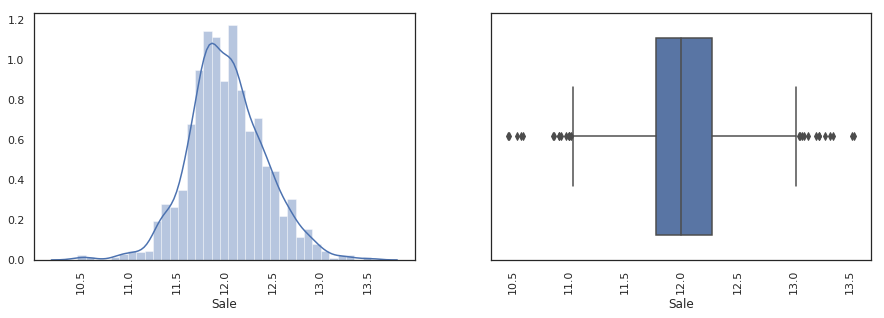

In [6]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.distplot(housing_train['Sale'])
plt.xticks(rotation=90)
plt.subplot(2,2,2)
sns.boxplot(housing_train['Sale'])
plt.xticks(rotation=90)
plt.show()

In [7]:
sale_price_labels = housing_train.pop('Sale')

sale_price = housing_train.pop('SalePrice')

housing_train.shape, housing_test.shape

((1460, 80), (1459, 80))

In [8]:
housing_full = pd.concat([housing_train,housing_test], axis=0)

housing_full.shape

(2919, 80)

##Data Cleaning

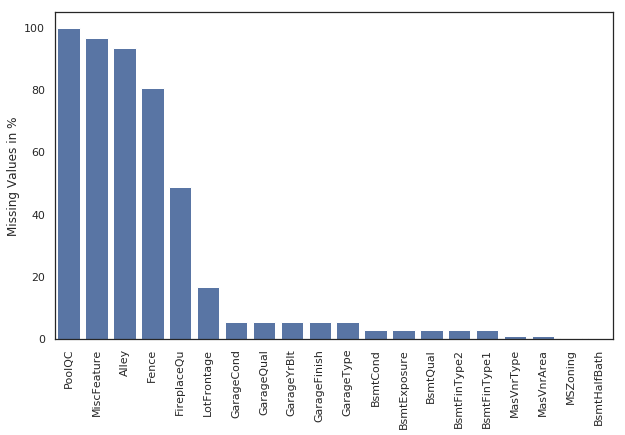

In [9]:
null_percent = (housing_full.isnull().sum().sort_values(ascending=False)/len(housing_full) * 100)[:20]
plt.figure(figsize=(10,6))
sns.barplot(x=null_percent.index, y=null_percent, color='b')
plt.ylabel("Missing Values in %")
plt.xticks(rotation='90')
plt.show()




At first it seems to remove column with most missing values, but when I refered data description, it seems it might be important factor for the sale of the any house. So, I decided to fill with completely new values in the columns which has more than 50% missing values. I filled  columns: PoolQC, MiscFeature, Fence, Alley with only two values YES or NO i.e, any given given house has these feature or not. If it has then Y and N otherwise.

In [10]:
housing_full.loc[housing_full['PoolQC'].isin(['Ex', 'Gd', 'TA', 'Fa']), 'PoolQC'] = 'Y'
housing_full.loc[housing_full['PoolQC'] != 'Y', 'PoolQC'] = 'N'

housing_full.loc[housing_full['Alley'].isin(['Grvl','Pave']), 'Alley'] = 'Y'
housing_full.loc[housing_full['Alley'] != 'Y', 'Alley'] = 'N'

housing_full.loc[housing_full['Fence'].isin(['GdPrv','MnPrv', 'GdWo', 'MnWw']), 'Fence'] = 'Y'
housing_full.loc[housing_full['Fence'] != 'Y', 'Fence'] = 'N'

housing_full.loc[housing_full['MiscFeature'].isin(['Elev','Gar2', 'Othr', 'Shed', 'TenC']), 'MiscFeature'] = 'Y'
housing_full.loc[housing_full['MiscFeature'] != 'Y', 'MiscFeature'] = 'N'


housing_full['FireplaceQu'] = housing_full['FireplaceQu'].fillna('NA')

len(housing_full.columns)

80

Features OverallQual, OverallCond, MSSubClass are infact categorical variable. I have transformed MSSubClass based on data description


Unplanned Single- US,
Unplanned Double - UD,
Unplanned Other - UO,
Planned Single- PS,
Planned Double - PD,
Planned Other - PO

In [0]:
housing_full.loc[housing_full['MSSubClass'] < 60, 'DwellType'] = 'US'
housing_full.loc[(housing_full['MSSubClass']>=60) & (housing_full['MSSubClass']<80), 'DwellType'] = 'UD'
housing_full.loc[(housing_full['MSSubClass']>=80) & (housing_full['MSSubClass']<100), 'DwellType'] = 'UO'
housing_full.loc[(housing_full['MSSubClass']>100) & (housing_full['MSSubClass']<=150), 'DwellType'] = 'PS'
housing_full.loc[housing_full['MSSubClass'] == 160, 'DwellType'] = 'PD'
housing_full.loc[housing_full['MSSubClass'] > 160, 'DwellType'] = 'PO'

housing_full['OverallQual'] = housing_full['OverallQual'].astype('category')
housing_full['OverallCond'] = housing_full['OverallCond'].astype('category')
housing_full['MSSubClass'] = housing_full['MSSubClass'].astype('category')



housing_full['MSSubClass'] = housing_full['DwellType']

housing_full = housing_full.drop('DwellType', axis=1)

Now, we will look at columns with year or month data. Age of any house plays an important role when it any house is being evaluated. Now I have created few columns with age information for better understanding. 

In [12]:
housing_full[['YrSold', 'YearBuilt', 'YearRemodAdd', 'MoSold', 'GarageYrBlt']].isnull().sum()


YrSold            0
YearBuilt         0
YearRemodAdd      0
MoSold            0
GarageYrBlt     159
dtype: int64

In [0]:
housing_full['GarageYrBlt'] = housing_full['GarageYrBlt'].fillna(housing_full['YearBuilt'])

In [0]:
housing_full['HouseAge'] = housing_full['YrSold'] - housing_full['YearBuilt'] + housing_full['MoSold']/12.0 
housing_full['RemodelAge'] = housing_full['YrSold'] - housing_full['YearRemodAdd'] + housing_full['MoSold']/12.0 
housing_full['GarageAge'] = housing_full['YrSold'] - housing_full['GarageYrBlt'] + housing_full['MoSold']/12.0 



In [15]:
housing_full[['HouseAge', 'RemodelAge', 'GarageAge']].head()

,HouseAge,RemodelAge,GarageAge
0,5.166667,5.166667,5.166667
1,31.416667,31.416667,31.416667
2,7.750000,6.750000,7.750000
3,91.166667,36.166667,8.166667
4,9.000000,9.000000,9.000000


In [0]:
housing_full = housing_full.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold'], axis=1)

In [0]:
housing_full['LotFrontage'] = housing_full['LotFrontage'].fillna(housing_full['LotFrontage'].mean())

In [18]:
housing_full.isnull().sum().sort_values(ascending=False).head(10)

GarageCond      159
GarageFinish    159
GarageQual      159
GarageType      157
BsmtCond         82
BsmtExposure     82
BsmtQual         81
BsmtFinType2     80
BsmtFinType1     79
MasVnrType       24
dtype: int64

In [19]:
print("GarageQual: {}".format(housing_full['GarageQual'].unique()[:10]))
print("GarageFinish: {}".format(housing_full['GarageFinish'].unique()[:10]))
print("GarageCond: {}".format(housing_full['GarageCond'].unique()[:10]))
print("GarageType: {}".format(housing_full['GarageType'].unique()[:10]))

GarageQual: ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
GarageFinish: ['RFn' 'Unf' 'Fin' nan]
GarageCond: ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
GarageType: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']


In [0]:
housing_full.fillna(housing_full.mode().iloc[0], inplace = True)


In [21]:
housing_full.isnull().sum().sort_values(ascending=False).head(5)

GarageAge      0
BsmtQual       0
Exterior1st    0
Exterior2nd    0
MasVnrType     0
dtype: int64

## Feature Engineering

In [22]:

housing_train = housing_full[:1460]

housing_train['Sale'] = sale_price_labels

col_num = housing_train._get_numeric_data().columns
col_num

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Index(['Id', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'HouseAge', 'RemodelAge', 'GarageAge', 'Sale'],
      dtype='object')

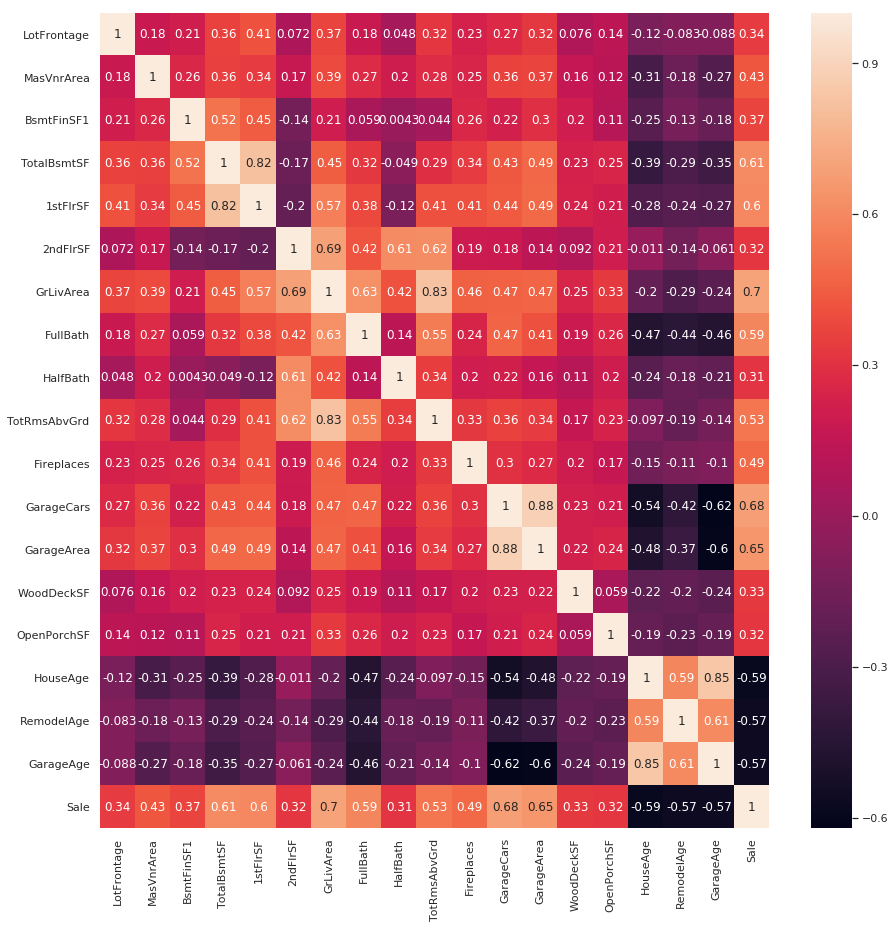

In [23]:

corr_matrix = housing_train[col_num.drop('Id')].corr()
top_corr = corr_matrix.index[abs(corr_matrix['Sale'])>0.3] # take only important features
plt.figure(figsize=(15, 15))
sns.heatmap(housing_train[top_corr].corr(), annot=True)

##ANOVA Test

In [24]:
col_cat = [] #list of categorical features

for x in housing_train.columns:
  if x not in  housing_train._get_numeric_data().columns:
    col_cat.append(x)
    

len(col_cat)

46

In [0]:
#!pip install pingouin
import pingouin as pg
def p_value(data, x):
   
    p = data.anova(dv='Sale', between=x, detailed=True)
    
    return p['p-unc'].values[0]

In [0]:
p_values = {}
for c in col_cat:
  p_values[c] = p_value(housing_train, c)

In [0]:
significance_level = 0.05
col_sig = [c for c in col_cat if p_values[c] < significance_level]

In [0]:
p_value_df = pd.DataFrame(p_values.items(), columns=['Attribute','P_Value'])
p_value_df = p_value_df.sort_values(['P_Value'], ascending=True)

p_value_df = p_value_df[p_value_df['P_Value']<significance_level]

In [0]:
c_iter = list(p_value_df['Attribute'].values)


##Chi-Squared Test

In [30]:
significant_cols = np.concatenate([col_sig, list(top_corr.drop('Sale'))])

housing_full = housing_full[significant_cols]

housing_full.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,LotFrontage,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,HouseAge,RemodelAge,GarageAge
0,UD,RL,Pave,N,Reg,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,N,N,N,WD,Normal,65.0,196.0,706.0,856.0,856,854,1710,2,1,8,0,2.0,548.0,0,61,5.166667,5.166667,5.166667
1,US,RL,Pave,N,Reg,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,N,N,N,WD,Normal,80.0,0.0,978.0,1262.0,1262,0,1262,2,0,6,1,2.0,460.0,298,0,31.416667,31.416667,31.416667
2,UD,RL,Pave,N,IR1,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,N,N,N,WD,Normal,68.0,162.0,486.0,920.0,920,866,1786,2,1,6,1,2.0,608.0,0,42,7.750000,6.750000,7.750000
3,UD,RL,Pave,N,IR1,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,N,N,N,WD,Abnorml,60.0,0.0,216.0,756.0,961,756,1717,1,0,7,1,3.0,642.0,0,35,91.166667,36.166667,8.166667
4,UD,RL,Pave,N,IR1,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,N,N,N,WD,Normal,84.0,350.0,655.0,1145.0,1145,1053,2198,2,1,9,1,3.0,836.0,192,84,9.000000,9.000000,9.000000


In [31]:
#Remove any other columns which are dependent.
dependent_col = []
for c1 in c_iter:
    for c2 in c_iter:
      x, y, stats = pg.chi2_independence(housing_full, x = c1, y = c2)
      dependent_col.append([c1,c2,stats['p'][0]])
        


len(dependent_col)

/usr/local/lib/python3.6/dist-packages/pingouin/contingency.py:149: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
/usr/local/lib/python3.6/dist-packages/pingouin/contingency.py:149: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:5057: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:5057: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:5054: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


1849

In [32]:
#dependent pairs
dependent_cols = pd.DataFrame(dependent_col, columns=['Col1', 'Col2', 'P_Value'])

dependent_cols = dependent_cols[dependent_cols['P_Value'] > 0.05] #Significance Level to reject NULL hypothesis

dependent_cols.head()
#Lets check if col_high_sig features 



,Col1,Col2,P_Value
36,OverallQual,LotConfig,0.096643
83,Neighborhood,PoolQC,0.215762
164,KitchenQual,Alley,0.061809
165,KitchenQual,LotConfig,0.419678
210,BsmtQual,RoofMatl,0.085422


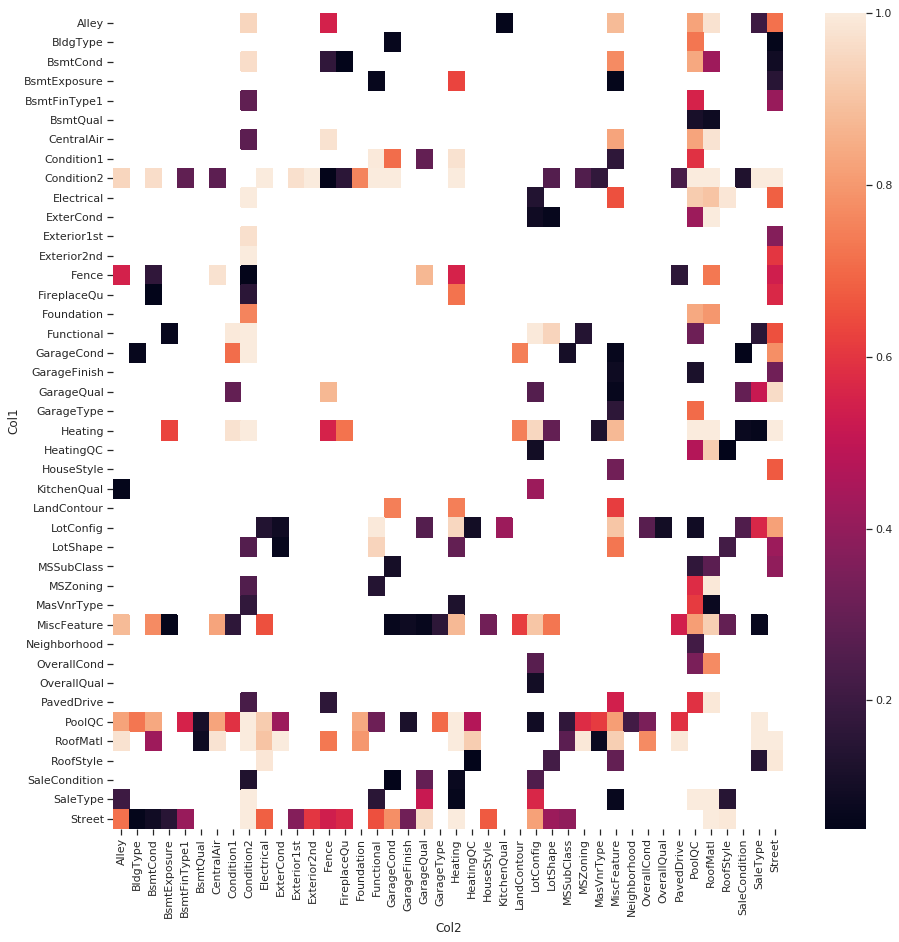

In [33]:
dependence_mat = dependent_cols.pivot("Col1", "Col2", "P_Value")

plt.figure(figsize=(15,15))
sns.heatmap(dependence_mat)


In [34]:
dependent_columns = []
for x in list(dependent_cols['Col1'].values):
  for y in list(dependent_cols[dependent_cols['Col1'] == x]['Col2'].values):
    if y not in dependent_columns:
      if p_values[x] < p_values[y]:
        dependent_columns.append(y)
  
dependent_columns, len(dependent_columns)

(['LotConfig',
  'PoolQC',
  'Alley',
  'RoofMatl',
  'MiscFeature',
  'Street',
  'BsmtCond',
  'Heating',
  'Condition2',
  'RoofStyle',
  'Functional',
  'GarageCond',
  'Fence',
  'GarageQual',
  'ExterCond',
  'Condition1',
  'LandContour'],
 17)

In [0]:
col_encode = [x for x in col_sig if x not in dependent_columns]

In [36]:
len(col_sig), len(dependent_columns), len(col_encode)

(43, 17, 26)

### Data Preparation

In [37]:
#Numeric variable

housing_full = housing_full.drop(dependent_columns, axis=1)

housing_full.shape

(2919, 44)

In [0]:
#housing_train = housing_train.drop('Sale', axis=1)
for c in col_encode:
  var_en = pd.get_dummies(housing_full[c], prefix = c)
  housing_full = pd.concat([housing_full, var_en], axis=1)



In [0]:
housing_full.drop(col_encode, axis=1, inplace=True)


In [0]:
X_train = housing_full[:1460]
Y_train = sale_price_labels

In [0]:
X_test = housing_full[1460:]

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[top_corr.drop('Sale')] = scaler.fit_transform(X_train[top_corr.drop('Sale')])

X_test[top_corr.drop('Sale')] = scaler.fit_transform(X_test[top_corr.drop('Sale')])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [43]:
X_train.shape, X_test.shape

((1460, 198), (1459, 198))

In [44]:
Y_train.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: Sale, dtype: float64

#Model Selection

In [0]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings("ignore")


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

mse = make_scorer(mean_squared_error)

In [46]:
rmse_score = {}

#Ridge Model

ridreg = Ridge()
ridreg_score = cross_validate(ridreg,X_train, Y_train, cv=10, scoring = mse)
rmse_score['Ridge'] = np.sqrt(np.mean(ridreg_score['test_score']))

#RandomForest

ranreg = RandomForestRegressor()
ranreg_score = cross_validate(ranreg,X_train, Y_train, cv=10, scoring = mse)
rmse_score['Random'] = np.sqrt(np.mean(ranreg_score['test_score']))



#Lasso Model

lassreg = Lasso()
lassreg_score = cross_validate(lassreg,X_train, Y_train, cv=10, scoring = mse)
rmse_score['Lasso'] = np.sqrt(np.mean(lassreg_score['test_score']))


#XGBoost Model

xgbreg = XGBRegressor()
xgbreg_score = cross_validate(xgbreg,X_train, Y_train, cv=10, scoring = mse)
rmse_score['XGBoost'] = np.sqrt(np.mean(xgbreg_score['test_score']))

[19:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [47]:
rmse_score

{'Lasso': 0.39956841578485275,
 'Random': 0.15244359136617902,
 'Ridge': 0.14781647387205937,
 'XGBoost': 0.1367084205880175}

##Parameter Tuning

##XGBoost

In [48]:
#GridSearch for XGBoost
'''
xgbreg = XGBRegressor()
grid={
     'learning_rate':np.arange(0.1,0.3,0.01), 
      'objective': ['reg:squarederror'],
      'seed':[100],
      'eval_metric':['rmse'],
      'gamma':np.arange(0,0.01,0.001),
      'subsample': [0.5],
      'min_child_weight': [3],
      'colsample_bytree': [0.7],
      'max_depth':[5]
      
                }
xgb_grid = RandomizedSearchCV(xgbreg, grid, scoring=mse, n_jobs = -1, verbose=2, cv=4)
xgb_grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",xgb_grid.best_params_)
print("rmse :",np.sqrt(xgb_grid.best_score_))

'''

'\nxgbreg = XGBRegressor()\ngrid={\n     \'learning_rate\':np.arange(0.1,0.3,0.01), \n      \'objective\': [\'reg:squarederror\'],\n      \'seed\':[100],\n      \'eval_metric\':[\'rmse\'],\n      \'gamma\':np.arange(0,0.01,0.001),\n      \'subsample\': [0.5],\n      \'min_child_weight\': [3],\n      \'colsample_bytree\': [0.7],\n      \'max_depth\':[5]\n      \n                }\nxgb_grid = RandomizedSearchCV(xgbreg, grid, scoring=mse, n_jobs = -1, verbose=2, cv=4)\nxgb_grid.fit(X_train,Y_train)\nprint("tuned hpyerparameters :(best parameters) ",xgb_grid.best_params_)\nprint("rmse :",np.sqrt(xgb_grid.best_score_))\n\n'

In [53]:
param = {'subsample': 0.5, 'min_child_weight': 3, 
         'learning_rate': 0.07,'gamma': 0.004, 'colsample_bytree': 0.9, 
         'n_estimators':1000, 'max_depth':5,
         'seed': 100, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

xgbreg = XGBRegressor(**param)

xgbreg.fit(X_train, Y_train)

Y_pred = xgbreg.predict(X_train)
rmse_xgb = np.sqrt(mean_squared_error(Y_pred, Y_train))

rmse_xgb


0.02187429294616892

In [54]:
#Finally XGBoost will be selected.

Y_pred = np.expm1(xgbreg.predict(X_test))
price_predicted = pd.Series(Y_pred,name="SalePrice")
house_id = pd.Series(test_ids,name="Id").astype(int)

submission = pd.concat([house_id, price_predicted], axis=1)

submission.head()

,Id,SalePrice
0,1461,120143.242188
1,1462,156572.656250
2,1463,191150.187500
3,1464,211654.921875
4,1465,175906.562500


In [0]:
submission.to_csv('submission.csv', index=False)